In [47]:
from skimage import io
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from skimage.transform import pyramid_gaussian
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.filters import sobel
from skimage.color import rgb2gray
from skimage import feature
from torch.autograd import Function
import cv2
from IPython.display import clear_output
import pandas as pd
from skimage.io import imsave


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Load images

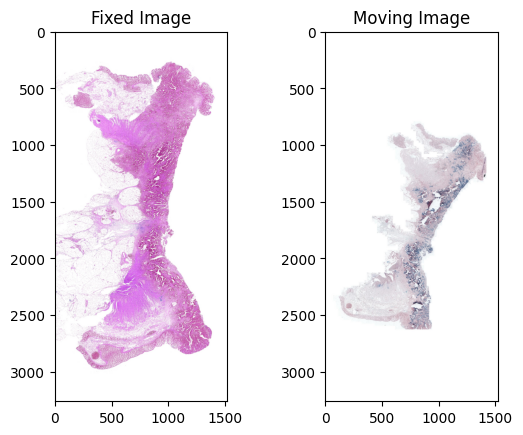

In [48]:
# I = io.imread("images/AANLIB/case2_ct1_012.gif").astype(np.float32) # fixed image
# J = io.imread("images/AANLIB/case2_mr2_012.gif").astype(np.float32) # moving image

I = io.imread("images/ANHIR/fixed2.jpeg").astype(np.float32) # fixed image
J = io.imread("images/ANHIR/moving2.jpeg").astype(np.float32) # moving image

# Ensure image data shape is correct
I = np.squeeze(I)
J = np.squeeze(J)

if np.ndim(I) == 2:
    fig=plt.figure()
    fig.add_subplot(1,2,1)
    plt.imshow(I/255, cmap='gray')
    plt.title("Fixed Image")
    fig.add_subplot(1,2,2)
    plt.imshow(J/255, cmap='gray') 
    plt.title("Moving Image")
    plt.show()
else:
    fig=plt.figure()
    fig.add_subplot(1,2,1)
    plt.imshow(I/255)
    plt.title("Fixed Image")
    fig.add_subplot(1,2,2)
    plt.imshow(J/255) 
    plt.title("Moving Image")
    plt.show()


### Create Gaussian Pyramid

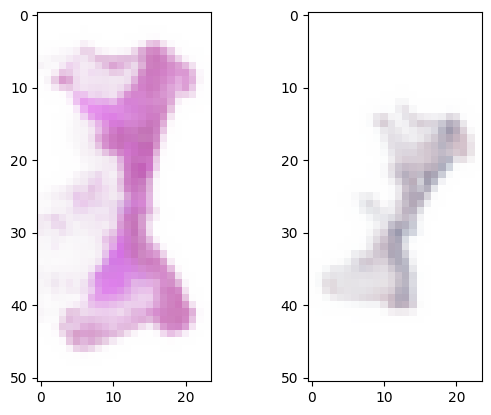

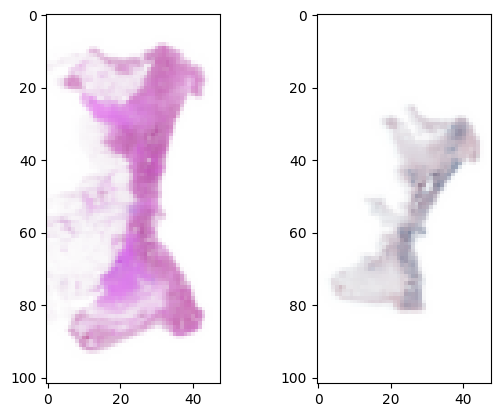

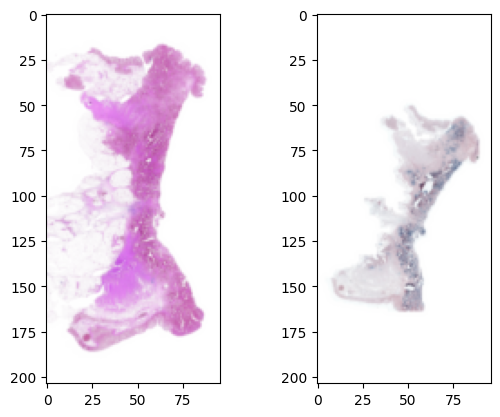

In [49]:
downscale = 2.0
ifplot=True

if np.ndim(I) == 3:
    nChannel=I.shape[2]
    # pyramid_I = tuple(pyramid_gaussian(gaussian(I, sigma=1, multichannel=True), downscale=downscale, multichannel=True))
    # pyramid_J = tuple(pyramid_gaussian(gaussian(J, sigma=1, multichannel=True), downscale=downscale, multichannel=True))
    pyramid_I = tuple(pyramid_gaussian(gaussian(I, sigma=1, channel_axis=-1), downscale=downscale, channel_axis=-1))
    pyramid_J = tuple(pyramid_gaussian(gaussian(J, sigma=1, channel_axis=-1), downscale=downscale, channel_axis=-1))
elif np.ndim(I) == 2:
    nChannel=1
    # pyramid_I = tuple(pyramid_gaussian(gaussian(I, sigma=1, multichannel=False), downscale=downscale, multichannel=False))
    # pyramid_J = tuple(pyramid_gaussian(gaussian(J, sigma=1, multichannel=False), downscale=downscale, multichannel=False))
    pyramid_I = tuple(pyramid_gaussian(gaussian(I, sigma=1, channel_axis=None), downscale=downscale, channel_axis=None))
    pyramid_J = tuple(pyramid_gaussian(gaussian(J, sigma=1, channel_axis=None), downscale=downscale, channel_axis=None))
else:
    print("Unknown rank for an image")

%matplotlib inline
for level in [6, 5, 4]:
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.imshow(pyramid_I[level]/255)
    fig.add_subplot(1,2,2)
    plt.imshow(pyramid_J[level]/255) 
    plt.show()


### Cross Correlation as Similarity Metric

In [50]:
def cross_correlation(I, J):
    # Mean centering the images
    I_mean = I - torch.mean(I)
    J_mean = J - torch.mean(J)
    
    # Calculating the cross-correlation
    numerator = torch.sum(I_mean * J_mean)
    denominator = torch.sqrt(torch.sum(I_mean ** 2) * torch.sum(J_mean ** 2))
    
    # Stability check to prevent division by zero
    if denominator == 0:
        return 0
    else:
        return numerator / denominator


### HomographyNet is used to apply matrix exponentiation to get transformation matrix H from vector v

In [51]:
class HomographyNet(nn.Module):
    def __init__(self):
        super(HomographyNet, self).__init__()
        # affine transform basis matrices

        self.B = torch.zeros(6,3,3).to(device)
        self.B[0,0,2] = 1.0
        self.B[1,1,2] = 1.0
        self.B[2,0,1] = 1.0
        self.B[3,1,0] = 1.0
        self.B[4,0,0], self.B[4,1,1] = 1.0, -1.0
        self.B[5,1,1], self.B[5,2,2] = -1.0, 1.0

        self.v1 = torch.nn.Parameter(torch.zeros(6,1,1).to(device), requires_grad=True)
        self.vL = torch.nn.Parameter(torch.zeros(6,1,1).to(device), requires_grad=True)

    def forward(self, s):
        C = torch.sum(self.B*self.vL,0)
        if s==0:
            C += torch.sum(self.B*self.v1,0)
        A = torch.eye(3).to(device)
        H = A
        for i in torch.arange(1,10):
            A = torch.mm(A/i,C)
            H = H + A
        return H

### AffineTransform

In [52]:
def AffineTransform(I, H, xv, yv):
    # apply affine transform
    xvt = (xv*H[0,0]+yv*H[0,1]+H[0,2])/(xv*H[2,0]+yv*H[2,1]+H[2,2])
    yvt = (xv*H[1,0]+yv*H[1,1]+H[1,2])/(xv*H[2,0]+yv*H[2,1]+H[2,2])
    J = F.grid_sample(I,torch.stack([xvt,yvt],2).unsqueeze(0)).squeeze()
    return J

def multi_resolution_loss():
    loss = 0.0
    for s in np.arange(L-1, -1, -1):
        Jw_ = AffineTransform(J_lst[s].unsqueeze(0), homography_net(s), xy_lst[s][:,:,0], xy_lst[s][:,:,1]).squeeze()
        cc = cross_correlation(I_lst[s], Jw_)
        loss -= (1./L) * cc  # Using negative because we need to maximize CC
    return loss


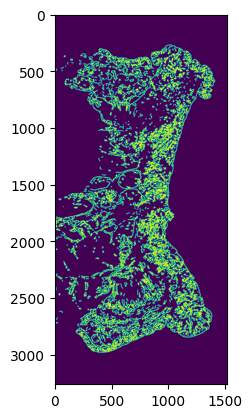

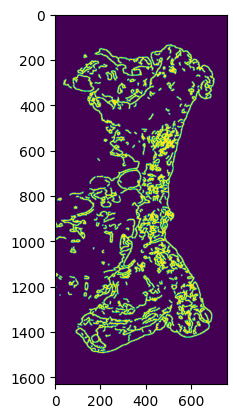

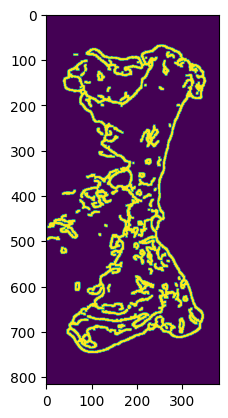

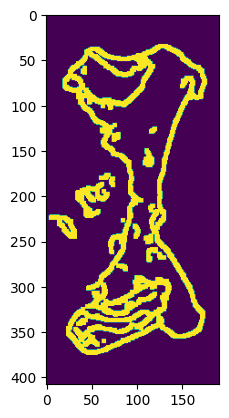

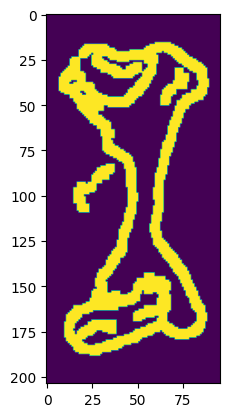

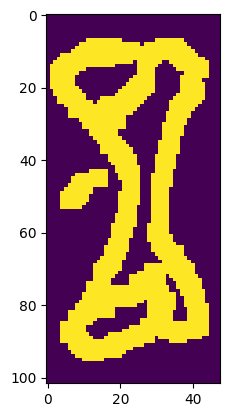

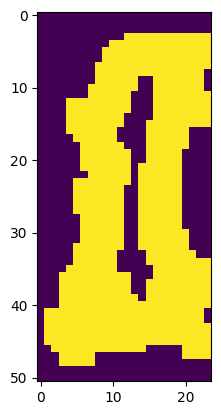

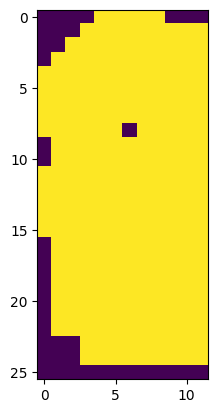

In [53]:
L = 8 # where registration starts (at the coarsest resolution)

# create a list of necessary objects you will need and commit to GPU
I_lst,J_lst,h_lst,w_lst,xy_lst,ind_lst=[],[],[],[],[],[]
for s in range(L):
    I_ = torch.tensor(cv2.normalize(pyramid_I[s].astype(np.float32), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)).to(device)
    J_ = torch.tensor(cv2.normalize(pyramid_J[s].astype(np.float32), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)).to(device)

    if nChannel>1:
        I_lst.append(I_.permute(2,0,1))
        J_lst.append(J_.permute(2,0,1))
        h_, w_ = I_lst[s].shape[1], I_lst[s].shape[2]

        edges_grayscale = cv2.dilate(cv2.Canny(cv2.GaussianBlur(rgb2gray(pyramid_I[s]),(21,21),0).astype(np.uint8), 0, 30),
                                 np.ones((5,5),np.uint8),
                                 iterations = 1)
        ind_ = torch.nonzero(torch.tensor(edges_grayscale).view(h_*w_)).squeeze().to(device)[:1000000]
        ind_lst.append(ind_)
    else:
        I_lst.append(I_)
        J_lst.append(J_)
        h_, w_ = I_lst[s].shape[0], I_lst[s].shape[1]

        edges_grayscale = cv2.dilate(cv2.Canny(cv2.GaussianBlur(pyramid_I[s],(21,21),0).astype(np.uint8), 0, 30),
                                 np.ones((5,5),np.uint8),
                                 iterations = 1)
        ind_ = torch.nonzero(torch.tensor(edges_grayscale).view(h_*w_)).squeeze().to(device)[:1000000]
        ind_lst.append(ind_)
    plt.imshow(edges_grayscale)
    plt.show()
    h_lst.append(h_)
    w_lst.append(w_)

    y_, x_ = torch.meshgrid([torch.arange(0,h_).float().to(device), torch.arange(0,w_).float().to(device)])
    y_, x_ = 2.0*y_/(h_-1) - 1.0, 2.0*x_/(w_-1) - 1.0
    xy_ = torch.stack([x_,y_],2)
    xy_lst.append(xy_)

### Optimize Gradient Descent along with Cross Correlation

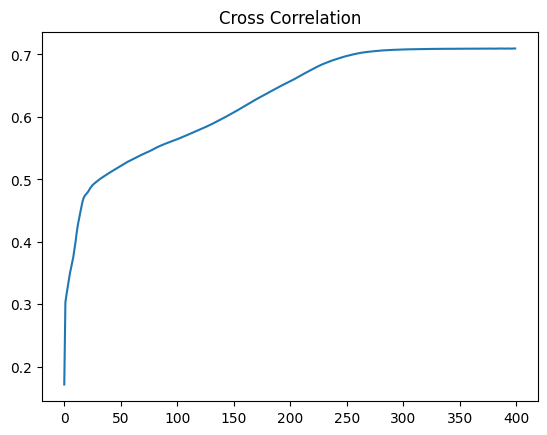

In [54]:
homography_net = HomographyNet().to(device)
optimizer = torch.optim.SGD([{'params': homography_net.parameters(), 'lr': 1e-2}])

cc_list = []
for itr in range(400):
    optimizer.zero_grad()
    loss = multi_resolution_loss()
    cc_list.append(-loss.item())  # Storing the cross correlation value
    loss.backward()
    optimizer.step()
    
    clear_output(wait=True)
    plt.plot(cc_list)
    plt.title("Cross Correlation")
    plt.show()


In [55]:
I_t = torch.tensor(I).to(device) # without Gaussian
J_t = torch.tensor(J).to(device) # without Gaussian
H = homography_net(0)
if nChannel>1:
    J_w = AffineTransform(J_t.permute(2,0,1).unsqueeze(0), H, xy_lst[0][:,:,0], xy_lst[0][:,:,1]).squeeze().permute(1,2,0)
else:
    J_w = AffineTransform(J_t.unsqueeze(0).unsqueeze(0), H , xy_lst[0][:,:,0], xy_lst[0][:,:,1]).squeeze()

Text(0.5, 1.0, 'Difference image after registration')

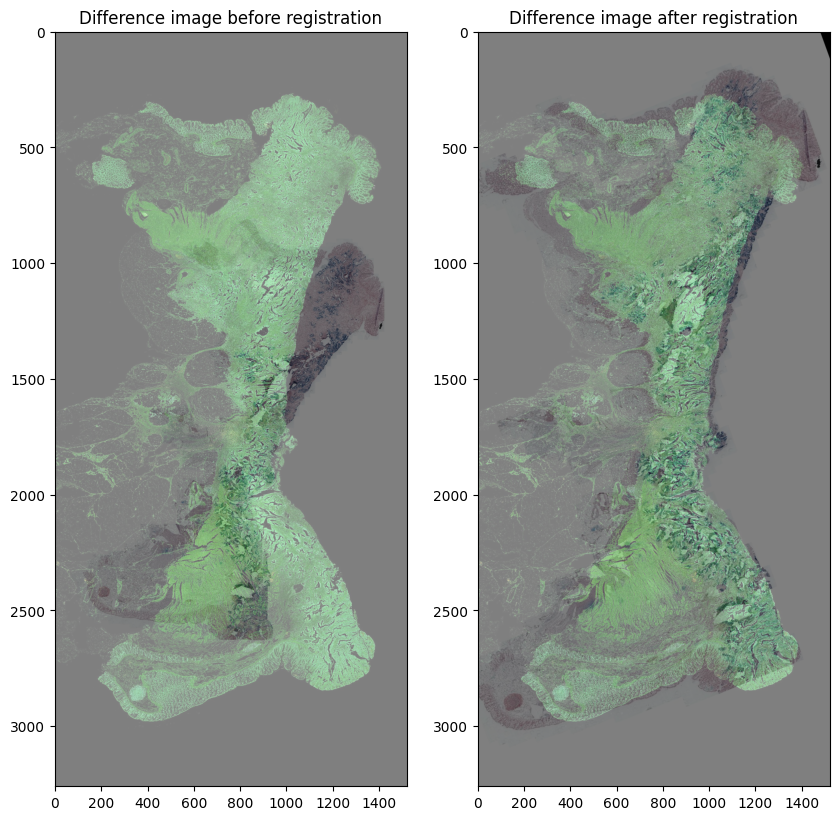

In [56]:
D = J_t - I_t
D_w = J_w - I_t
D = (D - torch.min(D))/(torch.max(D) - torch.min(D))
D_w = (D_w - torch.min(D_w))/(torch.max(D_w) - torch.min(D_w))
%matplotlib inline
fig=plt.figure(figsize=(10,10))
fig.add_subplot(1,2,1)
plt.imshow(D.cpu().data)
plt.title("Difference image before registration")
fig.add_subplot(1,2,2)
plt.imshow(D_w.cpu().data)         
plt.title("Difference image after registration")